In [2]:
import os
import json
from mathutils import Matrix
import numpy as np
from scipy.spatial.transform import Rotation


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from collections import Counter

In [3]:
# Specify the path to the dataset folder
dataset_path = '3RScan/data/train'

scenes = {}
i = 0

for scan_folder in os.listdir(dataset_path):
    scan_folder_path = os.path.join(dataset_path, scan_folder)

    # Check if the folder contains semseg.v2.json file
    semseg_file = os.path.join(scan_folder_path, 'semseg.v2.json')
    if not os.path.isfile(semseg_file):
        continue

    # Read and parse the semseg.v2.json file
    with open(semseg_file, 'r') as file:
        semseg_data = json.load(file)

    scan_id = semseg_data['scan_id']
    seg_groups = semseg_data['segGroups']
    
    extracted_objects = []

    # Extract individual objects
    for object_data in seg_groups:
        obj = {}
        # Extract necessary data from JSON
        axes_lengths = object_data['obb']['axesLengths']
        centroid = object_data['obb']['centroid']
        normalized_axes = object_data['obb']['normalizedAxes']
        
        
        # Print the extracted data for each object
        obj['id'] = object_data['objectId']
        obj['label'] = object_data['label']
        obj['location'] = centroid
        obj['size'] = axes_lengths
        obj['normalized_axes'] = normalized_axes
        
        if np.all(np.round(object_data['dominantNormal']) == np.array([0, -0, 1])):
            obj['dominantNormal'] = 1
        else:
            obj['dominantNormal'] = 0

        extracted_objects.append(obj)
        
    i += 1
    scenes[scan_id] = extracted_objects
    
print(len(scenes))


385


In [6]:
# Step 1: Extract x, y, and z coordinate values from all objects in all scenes
p = 95
x_values = []
y_values = []
z_values = []
for scene in scenes.values():
    for obj in scene:
        x_values.append(obj['location'][0])
        y_values.append(obj['location'][1])
        z_values.append(obj['location'][2])

# Step 2: Convert the lists of coordinate values to tensors
x_array = np.array(x_values)
y_array = np.array(y_values)
z_array = np.array(z_values)

# Step 3: Compute the percentiles of the x, y, and z coordinate values
percentile_x_loc_max = np.percentile(x_array, p)
percentile_y_loc_max = np.percentile(y_array, p)
percentile_z_loc_max = np.percentile(z_array, p)

print("location")
print('percentile p:', p)
print("percentile of x-coordinate values:", percentile_x_loc_max.item())
print("percentile of y-coordinate values:", percentile_y_loc_max.item())
print("percentile of z-coordinate values:", percentile_z_loc_max.item())

p=5
percentile_x_loc_min = np.percentile(x_array, p)
percentile_y_loc_min = np.percentile(y_array, p)
percentile_z_loc_min = np.percentile(z_array, p)


print("location")
print('percentile p:', p)
print("percentile of x-coordinate values:", percentile_x_loc_min.item())
print("percentile of y-coordinate values:", percentile_y_loc_min.item())
print("percentile of z-coordinate values:", percentile_z_loc_min.item())

# Step 4: Sort the coordinate arrays in descending order
x_sorted = np.sort(x_array)[::-1]
y_sorted = np.sort(y_array)[::-1]
z_sorted = np.sort(z_array)[::-1]

# Step 5: Print the highest 50 values for x, y, and z coordinates
print("Highest 20 values for x-coordinate:")
print(x_sorted[:20])

print("Highest 20 values for y-coordinate:")
print(y_sorted[:20])

print("Highest 20 values for z-coordinate:")
print(z_sorted[:20])
print("---------")

###

# Step 1: Extract x, y, and z coordinate values from all objects in all scenes
p = 95
x_sizes = []
y_sizes = []
z_sizes = []
for scene in scenes.values():
    for obj in scene:
        x_sizes.append(obj['size'][0])
        y_sizes.append(obj['size'][1])
        z_sizes.append(obj['size'][2])

# Step 2: Convert the lists of coordinate values to tensors
x_tensor_s = np.array(x_sizes)
y_tensor_s = np.array(y_sizes)
z_tensor_s = np.array(z_sizes)

# Step 3: Compute the percentiles of the x, y, and z coordinate values
percentile_x_s = np.percentile(x_tensor_s, p)
percentile_y_s = np.percentile(y_tensor_s, p)
percentile_z_s = np.percentile(z_tensor_s, p)

print("size")
print('percentile p:', p)
print("percentile of x-coordinate sizes:", percentile_x_s.item())
print("percentile of y-coordinate sizes:", percentile_y_s.item())
print("percentile of z-coordinate sizes:", percentile_z_s.item())

p = 5
percentile_x_s_min = np.percentile(x_tensor_s, p)
percentile_y_s_min = np.percentile(y_tensor_s, p)
percentile_z_s_min = np.percentile(z_tensor_s, p)

print("size")
print('percentile p:', p)
print("percentile of x-coordinate sizes:", percentile_x_s_min.item())
print("percentile of y-coordinate sizes:", percentile_y_s_min.item())
print("percentile of z-coordinate sizes:", percentile_z_s_min.item())

# Step 4: Sort the coordinate arrays in descending order
x_sorted_s = np.sort(x_tensor_s)[::-1]
y_sorted_s = np.sort(y_tensor_s)[::-1]
z_sorted_s = np.sort(z_tensor_s)[::-1]

# Step 5: Print the highest 50 values for x, y, and z coordinates
print("Highest 20 values for x-coordinate:")
print(x_sorted_s[:20])

print("Highest 20 values for y-coordinate:")
print(y_sorted_s[:20])

print("Highest 20 values for z-coordinate:")
print(z_sorted_s[:20])
print("---------")

###

# Step 1: Extract normalized_axes values from all objects in all scenes
normalized_axes_values = []
for scene in scenes.values():
    for obj in scene:
        normalized_axes_values.extend(obj['normalized_axes'])

# Step 2: Convert the list of normalized_axes values to a tensor
normalized_axes_tensor = np.array(normalized_axes_values)

# Step 3: Compute the 95th percentile of the normalized_axes values
p=95
percentile_na = np.percentile(normalized_axes_tensor, p)


print('percentile p:', p)
print("percentile of normalized_axes values:", percentile_na.item())

p=5
percentile_na_min = np.percentile(normalized_axes_tensor, p)


print('percentile p:', p)
print("percentile of normalized_axes values:", percentile_na_min.item())

location
percentile p: 95
percentile of x-coordinate values: 3.284515911563286
percentile of y-coordinate values: 3.9295290657423867
percentile of z-coordinate values: 0.8789122666192212
location
percentile p: 5
percentile of x-coordinate values: -3.33402531697188
percentile of y-coordinate values: -2.6193246561304426
percentile of z-coordinate values: -1.3288714361650238
Highest 20 values for x-coordinate:
[14.32088194 13.91667095 13.84534418 13.77987849 13.64370421 13.05003486
 12.85411481 12.63879497 12.57892585 12.52153895 12.46029311 12.33481002
 12.29900991 11.69039245 11.62358729 11.30650831 11.30357594 11.16532039
 11.02959254 11.01416871]
Highest 20 values for y-coordinate:
[1.99584026e+290 1.99584026e+290 1.58672076e+001 1.56955450e+001
 1.54839921e+001 1.54255276e+001 1.53262816e+001 1.52708230e+001
 1.51151697e+001 1.48840452e+001 1.48498379e+001 1.47258315e+001
 1.46536702e+001 1.45205024e+001 1.43569231e+001 1.40090805e+001
 1.39592440e+001 1.38982887e+001 1.38016977e+001

In [10]:
with open('test_small.json', 'r') as file:
    train_data = json.load(file)['scenes']
    
all_values = []
    
for scene in train_data:
    scene_matrix = np.array(scene["scene_matrix"])[:, :300]
    all_values.extend(scene_matrix.flatten())

percentile_10 = np.percentile(all_values, 10)
percentile_90 = np.percentile(all_values, 90)

print("10th percentile:", percentile_10)
print("90th percentile:", percentile_90)


10th percentile: -0.04789207503199577
90th percentile: 0.04962354153394699


### Analysis of all unfiltered scenes

Number of Scenes:  385
[37, 13, 41, 31, 11, 21, 25, 12, 16, 65, 54, 27, 26, 43, 48, 20, 33, 45, 40, 61, 14, 29, 29, 75, 52, 21, 21, 8, 28, 16, 29, 26, 58, 39, 35, 37, 42, 48, 69, 41, 25, 9, 34, 69, 7, 32, 31, 27, 52, 13, 19, 39, 39, 20, 36, 29, 33, 48, 14, 35, 29, 13, 35, 18, 14, 28, 39, 34, 21, 32, 32, 27, 21, 12, 55, 43, 17, 29, 16, 44, 14, 45, 12, 13, 28, 25, 17, 33, 23, 12, 40, 33, 17, 8, 30, 35, 16, 41, 2, 69, 29, 81, 41, 15, 34, 48, 39, 17, 25, 46, 42, 24, 35, 27, 22, 35, 24, 17, 32, 41, 9, 32, 28, 54, 48, 28, 17, 43, 13, 23, 39, 15, 33, 27, 28, 27, 23, 30, 44, 33, 13, 39, 47, 39, 14, 23, 32, 25, 73, 38, 23, 39, 48, 8, 62, 15, 35, 33, 37, 52, 35, 59, 30, 40, 47, 44, 10, 13, 18, 31, 16, 21, 47, 27, 22, 31, 17, 15, 63, 33, 25, 11, 17, 47, 28, 39, 28, 13, 3, 50, 29, 27, 45, 38, 20, 44, 19, 34, 18, 41, 25, 22, 24, 37, 21, 36, 62, 20, 22, 31, 10, 25, 7, 6, 48, 30, 11, 34, 39, 8, 42, 10, 31, 44, 40, 58, 77, 74, 30, 50, 27, 28, 47, 5, 34, 21, 19, 22, 14, 16, 31, 22, 12, 31, 43, 19, 3, 3

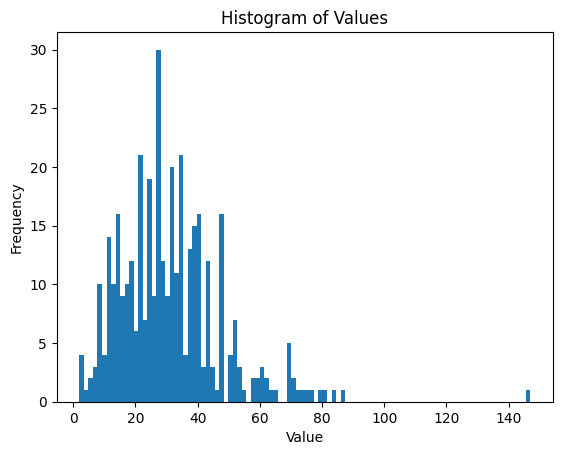

In [3]:
# number of scenes
print('Number of Scenes: ', len(scenes))

total_objects = []
for scan_id in scenes:
    total_objects.append(len(scenes[scan_id]))
print(total_objects)

# Create a histogram
plt.hist(total_objects, bins=100)  # Specify the number of bins or customize as needed

# Set labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')

# Display the histogram
plt.show()

## Filtering Scenes

In [4]:
filtered_scenes = {}
for scan_id in scenes:
    
    # Filter out objects with specified labels
    labels_to_remove = ['ceiling', 'wall', 'floor', 'plant', 'window', 'windowsill', 'shades', \
                       'wall frame', 'wall /other room', 'upholstered wall', 'glass wall', 'wall plants', \
                        'slanted wall', 'floor /other room', 'plants', 'doorframe', 'blinds', 'flowers', \
                       'item', 'object', 'items', 'window frame']
    filtered_scenes[scan_id] = [obj for obj in scenes[scan_id] if obj['label'] not in labels_to_remove]
    
    # Filter out objects with problematic dominant normal
    #filtered_scenes[scan_id] = [obj for obj in filtered_scenes[scan_id] if obj['dominantNormal']!=1]
    
    # Filter out objects, if we have too many
    #limit = 20
    #filtered_scenes[scan_id] = filtered_scenes[scan_id][:20]


## Analysis of all filtered scenes

[28, 12, 32, 23, 3, 12, 18, 9, 9, 43, 42, 17, 15, 25, 31, 13, 23, 33, 29, 44, 7, 20, 19, 37, 33, 12, 19, 4, 21, 8, 23, 13, 39, 31, 26, 26, 33, 34, 27, 29, 18, 5, 19, 45, 4, 28, 26, 18, 39, 6, 12, 29, 29, 15, 25, 18, 26, 40, 6, 26, 22, 7, 22, 13, 5, 16, 29, 20, 12, 23, 17, 21, 11, 8, 44, 33, 10, 18, 12, 29, 12, 31, 11, 9, 21, 17, 9, 19, 9, 8, 30, 27, 6, 7, 19, 25, 11, 25, 1, 49, 22, 66, 33, 9, 22, 41, 24, 11, 17, 31, 31, 18, 27, 18, 14, 24, 22, 11, 27, 28, 5, 23, 21, 38, 34, 17, 10, 31, 8, 14, 30, 9, 15, 22, 19, 20, 16, 16, 34, 18, 10, 27, 36, 26, 13, 16, 20, 18, 63, 23, 15, 33, 32, 4, 51, 6, 25, 25, 30, 25, 28, 42, 22, 24, 35, 33, 6, 9, 12, 25, 13, 17, 39, 19, 9, 18, 10, 11, 47, 19, 19, 9, 14, 36, 18, 29, 14, 4, 2, 28, 16, 18, 35, 27, 10, 27, 8, 23, 6, 31, 19, 10, 13, 27, 16, 15, 48, 8, 15, 24, 6, 11, 5, 5, 38, 25, 5, 27, 29, 7, 22, 8, 17, 23, 27, 25, 57, 54, 22, 37, 18, 22, 34, 3, 21, 11, 10, 12, 7, 11, 22, 10, 6, 21, 32, 14, 2, 20, 11, 29, 15, 7, 1, 14, 31, 27, 15, 26, 26, 21, 18, 27

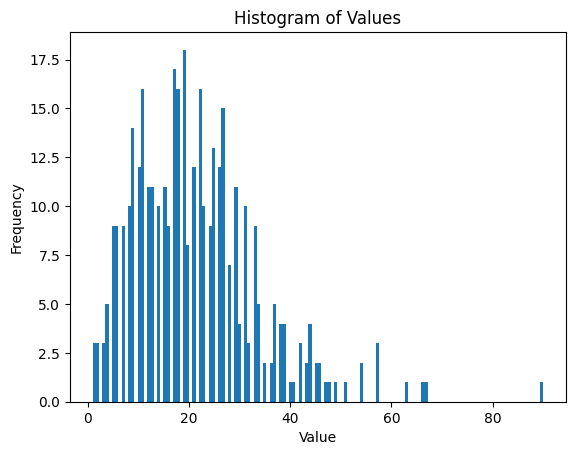

In [5]:
total_objects = []
for scan_id in filtered_scenes:
    total_objects.append(len(filtered_scenes[scan_id]))

# Create a histogram
plt.hist(total_objects, bins=140)  # Specify the number of bins or customize as needed

# Set labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')

# Display the histogram
plt.show()

Label: chair | Count: 688
Label: pillow | Count: 532
Label: box | Count: 482
Label: shelf | Count: 470
Label: lamp | Count: 298
Label: table | Count: 278
Label: door | Count: 254
Label: curtain | Count: 230
Label: picture | Count: 222
Label: cabinet | Count: 164
Label: bag | Count: 141
Label: light | Count: 131
Label: armchair | Count: 126
Label: clothes | Count: 119
Label: stool | Count: 118
Label: kitchen cabinet | Count: 113
Label: towel | Count: 110
Label: sink | Count: 105
Label: blanket | Count: 97
Label: commode | Count: 94
Label: trash can | Count: 90
Label: heater | Count: 85
Label: wardrobe | Count: 81
Label: bed | Count: 80
Label: bench | Count: 78
Label: desk | Count: 76
Label: sofa | Count: 72
Label: monitor | Count: 69
Label: basket | Count: 67
Label: cushion | Count: 65
Label: tv | Count: 59
Label: nightstand | Count: 56
Label: coffee table | Count: 50
Label: mirror | Count: 45
Label: bath cabinet | Count: 45
Label: rack | Count: 45
Label: toilet | Count: 42
Label: kitch

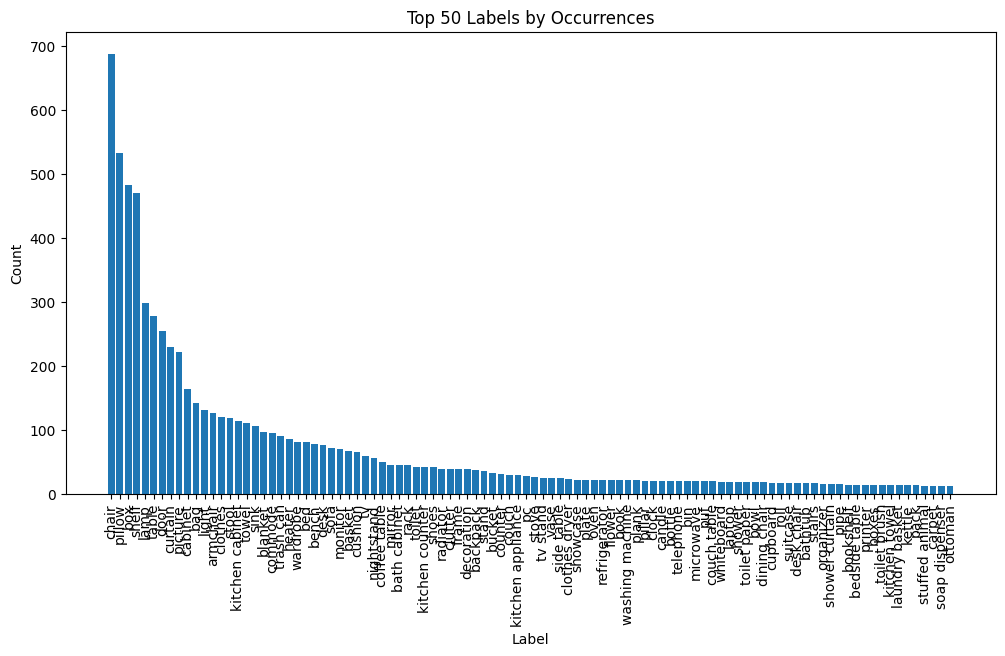

In [6]:
label_counts = Counter()

for scan_id in filtered_scenes:
    seg_groups = filtered_scenes[scan_id]
    for seg_group in seg_groups:
        label = seg_group.get("label")
        if label:
            label_counts[label] += 1
            
# Sort labels by count in descending order
sorted_labels = sorted(label_counts, key=label_counts.get, reverse=True)

# Print all labels and their counts
for label in sorted_labels:
    count = label_counts[label]
    print(f"Label: {label} | Count: {count}")


# Get the top 100 labels with the most occurrences
top_labels = label_counts.most_common(100)
labels, counts = zip(*top_labels)

print(labels)


# Set the figure size
plt.figure(figsize=(12, 6))

# Create a bar chart
plt.bar(labels, counts)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Top 50 Labels by Occurrences")
plt.xticks(rotation=90)
plt.show()

In [21]:
allowed_labels = ['chair', 'shelf', 'lamp', 'table', 'cabinet', 'light', 'armchair', 'stool', 'kitchen cabinet', 'sink', 'commode', 'trash can', 'heater', 'wardrobe', 'bed', 'bench', 'desk', 'sofa', 'monitor', 'tv', 'nightstand', 'coffee table', 'bath cabinet', 'rack', 'toilet', 'kitchen counter', 'radiator', 'stand', 'counter', 'couch', 'pc', 'stove', 'tv stand', 'side table', 'clothes dryer', 'showcase', 'oven', 'refrigerator', 'washing machine', 'bin', 'couch table', 'shower', 'dining chair', 'cupboard', 'desk chair', 'bathtub', 'organizer', 'shower curtain', 'bookshelf', 'bedside table', 'carpet']
print(len(allowed_labels))
for scan_id in filtered_scenes:
    filtered_scenes_2[scan_id] = [obj for obj in filtered_scenes[scan_id] if obj['label'] in allowed_labels]

label_counts = Counter()

for scan_id in filtered_scenes_2:
    seg_groups = filtered_scenes_2[scan_id]
    for seg_group in seg_groups:
        label = seg_group.get("label")
        if label:
            label_counts[label] += 1
            
# Sort labels by count in descending order
sorted_labels = sorted(label_counts, key=label_counts.get, reverse=True)

# Print all labels and their counts
for label in sorted_labels:
    count = label_counts[label]
    print(f"Label: {label} | Count: {count}")

51
Label: chair | Count: 688
Label: shelf | Count: 470
Label: lamp | Count: 298
Label: table | Count: 278
Label: cabinet | Count: 164
Label: light | Count: 131
Label: armchair | Count: 126
Label: stool | Count: 118
Label: kitchen cabinet | Count: 113
Label: sink | Count: 105
Label: commode | Count: 94
Label: trash can | Count: 90
Label: heater | Count: 85
Label: wardrobe | Count: 81
Label: bed | Count: 80
Label: bench | Count: 78
Label: desk | Count: 76
Label: sofa | Count: 72
Label: monitor | Count: 69
Label: tv | Count: 59
Label: nightstand | Count: 56
Label: coffee table | Count: 50
Label: bath cabinet | Count: 45
Label: rack | Count: 45
Label: toilet | Count: 42
Label: kitchen counter | Count: 42
Label: radiator | Count: 39
Label: stand | Count: 36
Label: counter | Count: 30
Label: couch | Count: 29
Label: pc | Count: 27
Label: stove | Count: 26
Label: tv stand | Count: 24
Label: side table | Count: 24
Label: clothes dryer | Count: 23
Label: showcase | Count: 22
Label: oven | Count

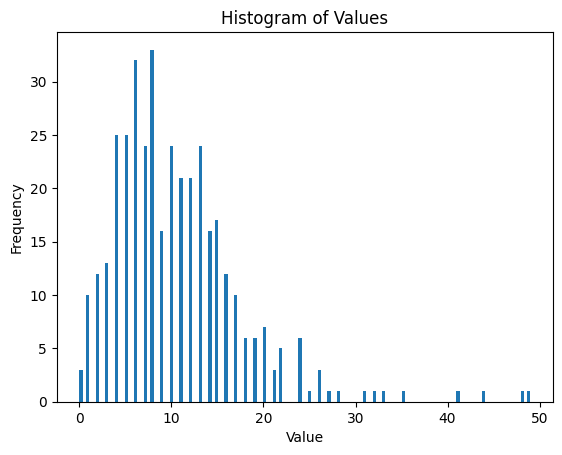

In [19]:
total_objects = []
for scan_id in filtered_scenes_2:
    total_objects.append(len(filtered_scenes_2[scan_id]))

# Create a histogram
plt.hist(total_objects, bins=140)  # Specify the number of bins or customize as needed

# Set labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')

# Display the histogram
plt.show()

In [ ]:
# Create Scene Matrix Data

In [76]:
scene_matrices = {}
for scene_id in filtered_scenes:
    # Extract values from the dataset
    locations = np.array([obj['location'] for obj in filtered_scenes[scene_id]])
    euler_angles = np.array([obj['euler_angles'] for obj in filtered_scenes[scene_id]])
    sizes = np.array([obj['size'] for obj in filtered_scenes[scene_id]])

    # Create the matrix
    stacked_matrix = np.hstack((locations, euler_angles, sizes))
    
    # Determine the desired number of rows
    desired_rows = 20

    # Add rows of zeros to each matrix
    scene_matrices[scene_id] = np.pad(stacked_matrix, [(0, desired_rows - stacked_matrix.shape[0]), (0, 0)], mode='constant')


In [77]:
print(scene_matrices['f4f31600-8408-2255-971c-b8c20605563a'])

[[ 1.26275718e+00  3.51208396e+00 -1.30000078e-01  1.57079633e+00
   0.00000000e+00 -3.41771455e-01  9.91616681e-01  2.71999997e+00
   5.72320205e-01]
 [ 4.87943595e-01  3.53441606e+00 -4.61602562e-01  1.57079633e+00
   0.00000000e+00 -5.44060096e-01  8.70828715e-01  4.96794973e-01
   4.67499190e-01]
 [ 4.08385676e-01  3.50626931e+00 -1.00000003e+00  1.57079633e+00
   0.00000000e+00 -5.51839495e-01  7.83675936e-01  8.59999935e-01
   7.25572164e-01]
 [ 1.12023500e+00  1.62539312e+00 -2.70218065e-01  1.57079633e+00
  -2.22044605e-16  1.26660255e+00  2.56271577e+00  2.27956391e+00
   6.87327407e-01]
 [-1.45828692e+00  3.07396521e-01 -9.31165075e-01  1.57079633e+00
   0.00000000e+00 -3.51407203e-01  1.84269128e+00  9.62330022e-01
   4.68365149e-01]
 [-1.60346762e+00  3.94241420e+00 -1.21937007e+00  1.57079633e+00
  -2.22044605e-16  1.22755206e+00  7.04980628e-01  4.98739947e-01
   3.91488116e-01]
 [-2.56726053e+00  1.58343214e+00 -8.17770072e-01  1.57079633e+00
   0.00000000e+00  1.0113547